In [147]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import seaborn
#import scipy.stats as stats
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
df = pd.read_csv('../data/hr_raw_data_definitivo.csv', index_col=0)
df.head()

,employee_number,attrition,job_level,job_role,department,monthly_income,salary,percent_salary_hike,training_times_last_year,stock_option_level,...,age,gender,marital_status,education,education_field,num_companies_worked,total_working_years,years_at_company,years_since_last_promotion,years_with_curr_manager
0,1,No,5,research director,research & development,16280.83,195370.00,13,5,0,...,52,M,NaN,3,other,7,NaN,20,15,15
1,2,No,5,manager,general,16665.83,199990.00,14,5,1,...,53,M,NaN,4,life sciences,0,34.0,33,11,9
2,3,No,5,manager,research & development,16026.67,192320.00,11,3,0,...,43,M,married,2,technical degree,1,22.0,22,11,15
3,4,No,4,research director,research & development,14307.50,171690.00,19,2,2,...,48,F,married,4,medical,3,NaN,20,5,6
4,5,No,4,sales executive,sales,12783.92,153407.04,12,5,1,...,47,F,divorced,3,technical degree,2,NaN,19,2,8


In [149]:
grupo_control = df[df['satisfaction'] == 'satisfied']

In [150]:
grupo_variante = df[df['satisfaction'] == 'not satisfied']

In [151]:
grupo_control_porcentaje_rotacion = grupo_control[grupo_control['attrition'] == 'Yes']["employee_number"].count()/grupo_control.shape[0]*100
print(grupo_control_porcentaje_rotacion)

13.668341708542714


In [152]:
grupo_variante_porcentaje_rotacion = grupo_variante[grupo_variante['attrition'] == 'Yes']["employee_number"].count()/grupo_variante.shape[0]*100
print(grupo_variante_porcentaje_rotacion)

19.87075928917609


### Marina y Fiona - 25.11.2024

    H0 = No existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.
    H1 = Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.

In [153]:
'''Hacemos una tabla de contingencia, ya que son dos variables categóricas, para ver las proporciones.'''
tabla_contingencia = pd.crosstab(df["satisfaction"], df["attrition"])

In [154]:
tabla_contingencia

attrition,No,Yes
satisfaction,,
not satisfied,496,123
satisfied,859,136


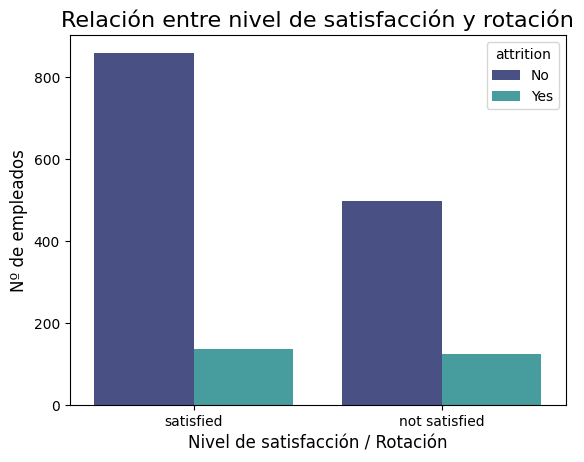

In [155]:
plot = sns.countplot( x="satisfaction", data=df, hue='attrition', palette="mako") 
plot.set_title("Relación entre nivel de satisfacción y rotación", fontsize=16) 
plot.set_xlabel("Nivel de satisfacción / Rotación", fontsize=12) 
plot.set_ylabel("Nº de empleados", fontsize=12);

In [156]:
'''Confirmar si nos quedamos con la H0 o la H1. En este caso calculamos el chi2 al tratarse de variables categóricas (proporciones).'''

_, p_value, _, _ = chi2_contingency(tabla_contingencia)
if p_value <= 0.05:
    print('Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.')
else:
    print('No existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.')

Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.


Rechazamos H0 y nos quedamos con la H1 - Existe una relación significativa entre el nivel de satisfacción y la rotación. 

### ¿Existe relación entre el salario y el nivel de rotación de los empleados?
    H0 = No existe relación entre el salario y el nivel de rotación de os empleados.
    H1 = Existe relación entre el salario y el nivel de rotación de os empleados.

In [157]:
grupo_control_rotacion = df[df['attrition'] == 'No']

In [158]:
grupo_variante_rotacion = df[df['attrition'] == 'Yes']

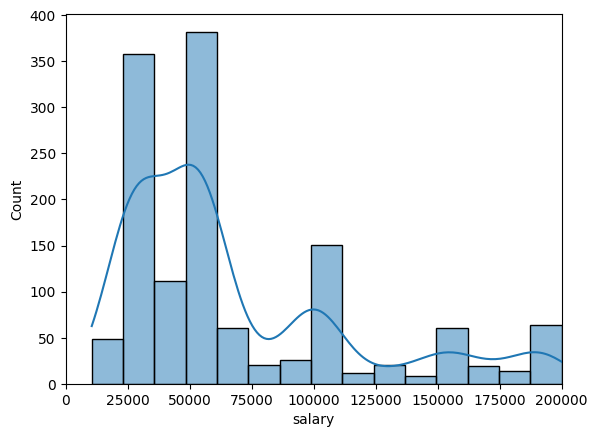

In [159]:
'''Visualización distribución salarios de empleados satisfechos.'''
sns.histplot(x= 'salary', data= grupo_control_rotacion, kde=True)
plt.xlim(0, 200000); 

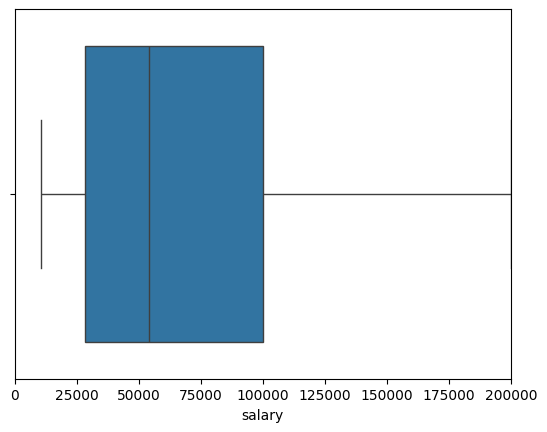

In [160]:
sns.boxplot(x= 'salary', data= grupo_control_rotacion)
plt.xlim(0, 200000); 

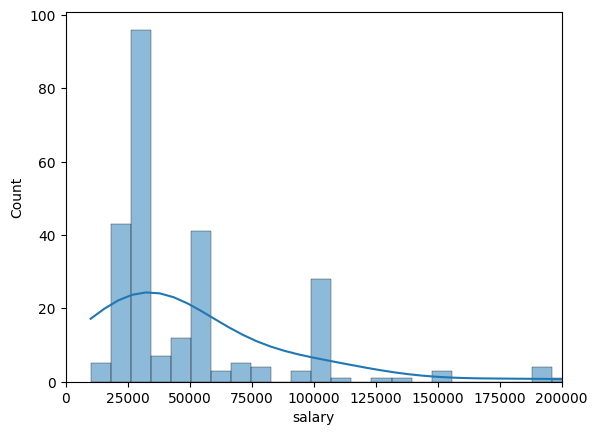

In [161]:
'''Visualización distribución salarios de empleados que se han ido de la empresa.'''
sns.histplot(x= 'salary', data= grupo_variante_rotacion, kde=True)
plt.xlim(0, 200000); 

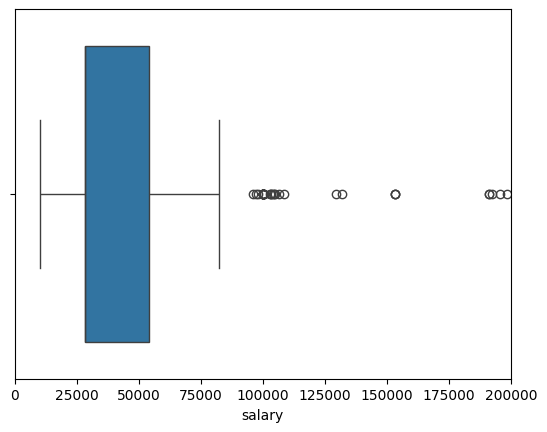

In [162]:
sns.boxplot(x= 'salary', data= grupo_variante_rotacion)
plt.xlim(0, 200000); 

In [163]:
def normalidad(dataframe, columna):

    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")

In [164]:
'''¿Siguen los datos salariales de los empleados que siguen en la empresa una distribución normal?'''
normalidad(grupo_control_rotacion, ['salary'])

Para la columna ['salary'] los datos no siguen una distribución normal.


In [165]:
'''¿Siguen los datos salariales de los empleados que se han ido de la empresa una distribución normal?'''
normalidad(grupo_variante_rotacion, ['salary'])

Para la columna ['salary'] los datos no siguen una distribución normal.


In [166]:
def test_man_whitney(dataframe, metricas, columna_grupos="attrition", grupo_control="No", grupo_variante="Yes"):
    # Verificar si la columna tiene los valores esperados
    grupos = dataframe[columna_grupos].unique()
    if not {grupo_control, grupo_variante}.issubset(grupos):
        raise ValueError(f"La columna '{columna_grupos}' debe contener los valores '{grupo_control}' y '{grupo_variante}'.")

    # Filtrar los datos para los dos grupos
    control = dataframe[dataframe[columna_grupos] == grupo_control]
    variante = dataframe[dataframe[columna_grupos] == grupo_variante]

    # Comprobar que ambos grupos tengan datos suficientes
    if control.empty or variante.empty:
        raise ValueError("Uno de los grupos no tiene datos suficientes para realizar el test.")

    # Realizar el test de Mann-Whitney para cada métrica
    for metrica in metricas:
        if metrica not in dataframe.columns:
            print(f"La métrica '{metrica}' no existe en el DataFrame.")
            continue

        metrica_control = control[metrica]
        metrica_variante = variante[metrica]

        # Aplicar el test de Mann-Whitney
        u_statistic, p_value = stats.mannwhitneyu(metrica_control, metrica_variante)

        # Mostrar los resultados
        if p_value < 0.05:
            print(f"Para la métrica '{metrica}', las medianas son diferentes (p = {p_value:.4f}).")
        else:
            print(f"Para la métrica '{metrica}', las medianas son iguales (p = {p_value:.4f}).")


test_man_whitney(df, ['salary']) 

Para la métrica 'salary', las medianas son diferentes (p = 0.0000).


### Rechazamos la hipótesis nula y afirmarmos que existe una relación entre el salario y la rotación de empleados.

In [167]:
full_time = df[df['standard_hours'] == 'Full Time']

In [168]:
part_time = df[df['standard_hours'] == 'Part Time']

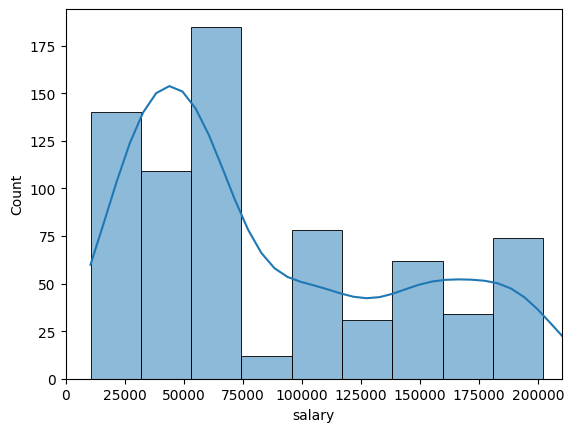

In [169]:
sns.histplot(x= 'salary', data= full_time, kde=True)
plt.xlim(0, 210000); 

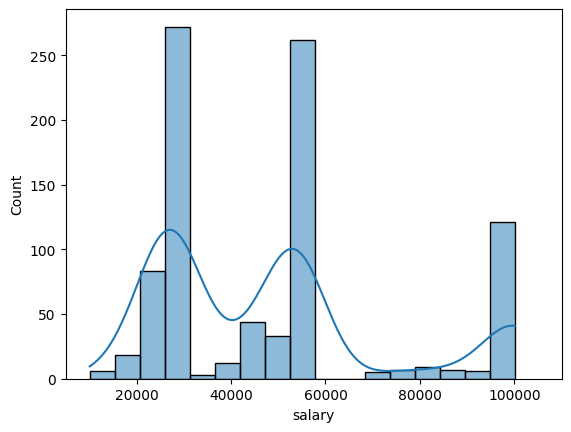

In [170]:
sns.histplot(x= 'salary', data= part_time, kde= True)
plt.xlim(5000, 110000); 

### Hacemos la prueba de M Whitney por separado, ya que no sabemos el equivalente del salario full time para los que trabajan a media jornada y podría afectar sobre cómo están distribuidos los salarios.

In [171]:
full_time

,employee_number,attrition,job_level,job_role,department,monthly_income,salary,percent_salary_hike,training_times_last_year,stock_option_level,...,age,gender,marital_status,education,education_field,num_companies_worked,total_working_years,years_at_company,years_since_last_promotion,years_with_curr_manager
0,1,No,5,research director,research & development,16280.83,195370.00,13,5,0,...,52,M,NaN,3,other,7,NaN,20,15,15
1,2,No,5,manager,general,16665.83,199990.00,14,5,1,...,53,M,NaN,4,life sciences,0,34.0,33,11,9
2,3,No,5,manager,research & development,16026.67,192320.00,11,3,0,...,43,M,married,2,technical degree,1,22.0,22,11,15
3,4,No,4,research director,research & development,14307.50,171690.00,19,2,2,...,48,F,married,4,medical,3,NaN,20,5,6
4,5,No,4,sales executive,sales,12783.92,153407.04,12,5,1,...,47,F,divorced,3,technical degree,2,NaN,19,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,1598,No,5,manager,general,15943.72,191324.62,13,4,1,...,43,M,NaN,3,other,1,24.0,24,14,9
1600,1601,Yes,2,sales executive,sales,4492.84,53914.08,16,3,0,...,56,M,single,1,medical,4,NaN,9,7,3
1608,1609,No,2,manufacturing director,research & development,5604.17,67250.00,12,2,1,...,33,F,married,4,medical,1,8.0,8,6,3
1609,1610,Yes,3,sales executive,sales,8604.17,103250.00,11,6,1,...,37,M,married,1,life sciences,1,NaN,16,3,7


In [172]:
# Prueba de Man Whitney para ver la relación entre el salario de los empleados part time y la rotación:

test_man_whitney(part_time, ['salary'], grupo_control='No', grupo_variante='Yes')

Para la métrica 'salary', las medianas son diferentes (p = 0.0000).


### ¿Existe relación entre el nivel de satisfacción del empleado con su worklifebalance y la rotación?

In [173]:
df['work_life_balance'].unique()

array([3., 2., 4., 1.])

In [174]:
def categorizar_worklife_balance(valor):
    if valor == 1:
        return 'Nada satisfecho'
    elif valor == 2:
        return 'Poco satisfecho'
    elif valor == 3:
        return 'Satisfecho'
    elif valor == 4:
        return 'Muy satisfecho'
    else:
        return 'Desconocido'

# Aplicar la función a la columna
df['work_life_balance_categoria'] = df['work_life_balance'].apply(categorizar_worklife_balance)

df[['work_life_balance', 'work_life_balance_categoria']]

,work_life_balance,work_life_balance_categoria
0,3.0,Satisfecho
1,3.0,Satisfecho
2,3.0,Satisfecho
3,3.0,Satisfecho
4,3.0,Satisfecho
...,...,...
1609,3.0,Satisfecho
1610,2.0,Poco satisfecho
1611,3.0,Satisfecho
1612,3.0,Satisfecho


In [175]:
tabla_contingencia1 = pd.crosstab(df["work_life_balance_categoria"], df["attrition"])
tabla_contingencia1

attrition,No,Yes
work_life_balance_categoria,,
Muy satisfecho,128,27
Nada satisfecho,56,23
Poco satisfecho,296,63
Satisfecho,875,146


In [176]:
_, p_value, _, _ = chi2_contingency(tabla_contingencia1)
if p_value <= 0.05:
    print('Existe una relación entre el nivel de satisfacción con el work life balance y la rotación de empleados en la empresa.')
else:
    print('No existe una relación entre el nivel de satisfacción con el work life balance y la rotación de empleados en la empresa.')

Existe una relación entre el nivel de satisfacción con el work life balance y la rotación de empleados en la empresa.


El análisis sugiere que, en general, los empleados con menor satisfacción en su balance entre vida y trabajo (por ejemplo, "Nada satisfechos" y "Poco satisfechos") tienen una mayor probabilidad de irse (rotación).

El grupo de empleados "Muy satisfechos" muestra una baja rotación, con mucho más empleados que se quedan.
Los empleados "Nada satisfechos" y "Poco satisfechos" muestran una proporción relativamente alta de rotación, lo que sugiere que la insatisfacción con el balance vida-trabajo está asociada con una mayor probabilidad de abandonar la empresa.

### ¿Hay empleados de departamentos específicos con una rotación significativamente más alta en comparación con el resto?

In [177]:
df.columns

Index(['employee_number', 'attrition', 'job_level', 'job_role', 'department',
       'monthly_income', 'salary', 'percent_salary_hike',
       'training_times_last_year', 'stock_option_level', 'hourly_rate',
       'daily_rate', 'monthly_rate', 'standard_hours', 'overtime',
       'business_travel', 'distance_from_home', 'remote_work',
       'environment_satisfaction', 'job_involvement', 'job_satisfaction',
       'satisfaction', 'performance_rating', 'relationship_satisfaction',
       'work_life_balance', 'date_birth', 'age', 'gender', 'marital_status',
       'education', 'education_field', 'num_companies_worked',
       'total_working_years', 'years_at_company', 'years_since_last_promotion',
       'years_with_curr_manager', 'work_life_balance_categoria'],
      dtype='object')

In [178]:
# Crear la tabla de contingencia entre departamento, rotación y satisfacción
tabla_contingencia2 = pd.crosstab(
    df['department'], df['attrition'])  

tabla_contingencia2


attrition,No,Yes
department,,
general,85,6
human resources,45,13
research & development,860,141
sales,365,99


In [179]:
chi2, p_value, dof, expected = chi2_contingency(tabla_contingencia2)

# Mostrar el resultado
print(f"Valor Chi-cuadrado: {chi2}")
print(f"Valor p: {p_value}")
print(f"Grados de libertad: {dof}")
print(f"Tabla esperada: \n{expected}")


Valor Chi-cuadrado: 20.274820329784614
Valor p: 0.00014887425794656543
Grados de libertad: 3
Tabla esperada: 
[[ 76.39714994  14.60285006]
 [ 48.69268897   9.30731103]
 [840.36864932 160.63135068]
 [389.54151177  74.45848823]]


La relación entre el departamento y la rotación de empleados es estadísticamente significativa. Esto sugiere que los empleados de diferentes departamentos tienen diferentes probabilidades de abandonar la empresa.

Si desearas un análisis más detallado, podrías observar las frecuencias observadas versus las esperadas para ver qué departamentos tienen mayores o menores tasas de rotación de lo que se esperaría si no hubiera ninguna relación.

Por ejemplo, en la tabla esperada, el departamento "research & development" tiene una cantidad significativa de empleados que permanecen (No), mientras que "sales" tiene una mayor cantidad de empleados que se van (Yes), en comparación con las frecuencias esperadas. Esto podría indicar que algunos departamentos tienen una rotación significativamente diferente a la media.

/var/folders/n5/d44x7lvd7t5f1m5bfx4hvw7w0000gn/T/ipykernel_12519/1903216678.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proporcion_rotacion', y='department', data=df, palette='viridis')


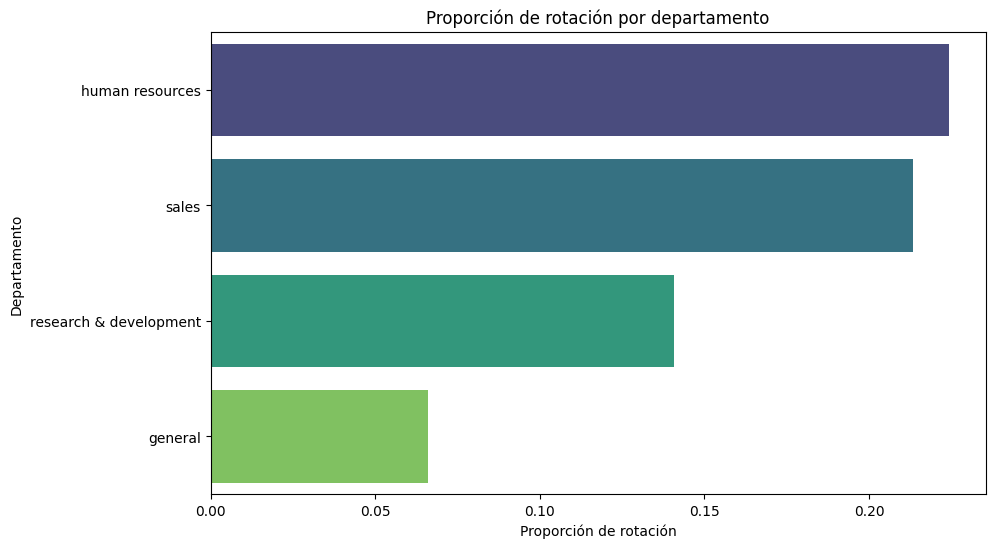

In [181]:
data = {
    'department': ['general', 'human resources', 'research & development', 'sales'],
    'No': [85, 45, 860, 365],
    'Yes': [6, 13, 141, 99]
}
df = pd.DataFrame(data)

# Calcular la proporción de rotación
df['proporcion_rotacion'] = df['Yes'] / (df['No'] + df['Yes'])

# Ordenar por proporción de rotación
df = df.sort_values(by='proporcion_rotacion', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='proporcion_rotacion', y='department', data=df, palette='viridis')
plt.title('Proporción de rotación por departamento')
plt.xlabel('Proporción de rotación')
plt.ylabel('Departamento')
plt.show()
